## **In-Class Activity: Customer Segmentation using Mall Customer Data**

### **Dataset**  
Use the **Mall Customer Segmentation Dataset** (available on [Kaggle](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)).

It contains:
- Customer ID
- Gender
- Age
- Annual Income (k$)
- Spending Score (1–100)

### **Activity Objective**

Apply and compare the performance of **K-Means**, **Hierarchical Clustering**, and **DBSCAN** to discover customer segments based on their income and spending behavior.


### **Instructions**

1. **Load and Explore the Dataset**  
   
2. **Apply Clustering Algorithms**  
   Implement the following:
   - **K-Means** (try different `K` values; use elbow method)
   - **K-Mediods** 
   - **Hierarchical Clustering** (use dendrogram to choose number of clusters)
   - **DBSCAN** (tune `eps` and `minPts`)

3. **Visualize the Clusters**  
   - Use scatter plots to visualize results of each algorithm.

4. **Evaluate the Clustering Results**  
   - Use **Silhouette Score** for internal validation.
   - Discuss the differences in how each algorithm handles cluster shapes and outliers.


### **Guiding Questions**

You might want to reflect on:
- Which algorithm performed best for this dataset and why?
- How does DBSCAN treat outliers differently from K-Means?
- What are the limitations of using only `Annual Income` and `Spending Score`?
- How would feature scaling affect DBSCAN’s performance?

### **Expected Learning Outcome**

By the end of this activity, you will:
- Understand the practical behavior of each algorithm
- Compare clustering shapes: spherical (K-Means), K-Mediods, nested (Hierarchical), and arbitrary (DBSCAN)
- Develop intuition for parameter tuning and internal validation metrics

# **Clustering Algorithms Overview**

## 1. **K-Means**
- **Type**: Centroid-based
- **Working**: Divides data into `k` clusters by minimizing the within-cluster sum of squared distances (inertia).
- **Strengths**: Fast, simple, effective on spherical and equally sized clusters.
- **Limitations**: Assumes clusters are isotropic; sensitive to initial centroid placement and outliers.

## 2. **K-Medoids**
A medoid is a representative object in a cluster whose average dissimilarity to all the other objects in the cluster is minimal. Unlike a centroid (which is an average point that may not exist in the dataset), a medoid is always an actual data point from the dataset.
- **Type**: Partitioning (similar to K-Means)
- **Working**: Instead of centroids, it uses actual data points (medoids) as centers. It minimizes the sum of dissimilarities.
- **Strengths**: More robust to outliers and noise than K-Means.
- **Limitations**: Computationally heavier than K-Means.

#### 3. **Hierarchical Clustering (Agglomerative)**
- **Type**: Hierarchical
- **Working**: Bottom-up approach where each point starts as a cluster and merges based on distance criteria (e.g., Ward linkage).
- **Strengths**: No need to pre-specify number of clusters; visual via dendrogram.
- **Limitations**: Computationally expensive for large datasets; hard to undo once merged.

#### 4. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
- **Type**: Density-based
- **Working**: Groups together points that are closely packed and marks low-density regions as noise.
- **Strengths**: Can find arbitrarily shaped clusters; handles noise well.
- **Limitations**: Sensitive to `eps` and `min_samples`; struggles with varying density.

#### 5. **BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)**
- **Type**: Hierarchical + Centroid-based hybrid
- **Working**: Builds a CF tree and clusters incrementally and hierarchically.
- **Strengths**: Efficient for very large datasets; scalable.
- **Limitations**: Performance degrades with non-spherical clusters or poor threshold selection.

### **Internal Validation Metrics**
Internal metrics assess the quality of the clustering based solely on the input data and the resulting labels, without relying on any ground truth.

---

#### 1. **Silhouette Score**

- **What it measures:**  
  How well each data point fits within its own cluster vs. other clusters.

- **Range:**  
  -1 (poor clustering) to +1 (ideal clustering), with ~0 indicating overlapping clusters.

- **Formula (for a point):**  
  $$
  s = \frac{b - a}{\max(a, b)}
  $$
  - $ a $ = average intra-cluster distance (within the same cluster)  
  - $ b $ = average nearest-cluster distance (to the nearest cluster that the point is not part of)

- **Use case:**  
  Useful to evaluate how compact and well-separated the clusters are.

---

#### 2. **Calinski-Harabasz Index (Variance Ratio Criterion)**

- **What it measures:**  
  Ratio of between-cluster dispersion to within-cluster dispersion.

- **Formula:**  
  $$
  CH = \frac{\text{Between-cluster variance}}{\text{Within-cluster variance}} \times \frac{(n - k)}{(k - 1)}
  $$
  - $ n $ = number of samples, $ k $ = number of clusters

- **Interpretation:**  
  Higher is better; a high value indicates well-separated and compact clusters.

---

#### 3. **Davies-Bouldin Index**

- **What it measures:**  
  Average similarity between each cluster and its most similar cluster (based on cluster diameter and distance).

- **Range:**  
  $\geq 0$; **lower is better**.

- **Formula:**  
  $$
  DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \ne i} \left( \frac{s_i + s_j}{d_{ij}} \right)
  $$
  - $ s_i $ = intra-cluster distance of cluster $ i $  
  - $ d_{ij} $ = inter-cluster distance between clusters $ i $ and $ j $

---

### **External Validation Metric**
External metrics compare the clustering result with a known ground truth.

---

#### 4. **Adjusted Rand Index (ARI)**

- **What it measures:**  
  Agreement between the clustering and the true class labels, adjusted for chance.

- **Range:**  
  From -1 to 1  
  - 1: Perfect match  
  - 0: Random labeling  
  - < 0: Worse than random

- **Use case:**  
  Effective when ground truth labels are available and you want to evaluate clustering accuracy.

---

### Summary Table

| **Metric**                | **Ideal Value** | **Interpretation**                              |
|---------------------------|------------------|--------------------------------------------------|
| Silhouette Score          | Close to 1       | High cohesion + separation                      |
| Calinski-Harabasz Index   | High             | High between-cluster & low within-cluster var.  |
| Davies-Bouldin Index      | Low              | Better inter-cluster separation                 |
| Adjusted Rand Index (ARI) | Close to 1       | Matches ground truth labeling                   |

In [58]:
# Customer Segmentation: Full Clustering Pipeline with Evaluation and Comparison (With and Without Hyperparameter Tuning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn_extra.cluster import KMedoids
from sklearn.model_selection import ParameterGrid
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

# Initial Setup with Annual Income and Spending Behavior only

# 1. DATA PREPARATION

In [59]:
df = pd.read_csv('mall_customers.csv')

x = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


In [60]:
df['Cluster_label'] = pd.cut(df['Spending Score (1-100)'], bins=3, labels = [0,1,2])
y_true = df['Cluster_label'].values

In [61]:
def evaluate_model(name, labels):
    unique_labels = set(labels)
    if len(unique_labels) >= 1:
        return {
            'Silhouette': -1,
            'CH': -1,
            'DB': -1,
            'ARI': -1,
        }
    filtered_data = x_scaled[labels != -1]
    filtered_labels = labels[labels != -1]

    return {
        'Silhouette': silhouette_score(filtered_data, filtered_labels),
            'CH': calinski_harabasz_score(filtered_data, filtered_labels),
            'DB': davies_bouldin_score(filtered_data, filtered_labels),
            'ARI': adjusted_rand_score(y_true[labels != -1], filtered_labels),
    }

# 2. BASELINE MODEL EVALUATION (No tuning)

In [62]:
baseline_results = {}


## KMeans Baseline + Elbow Plot

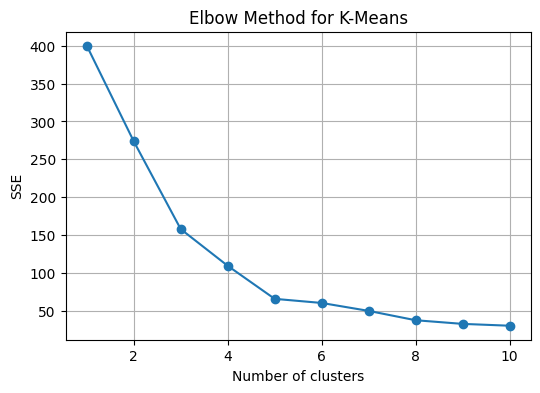

In [63]:
sse = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(x_scaled)
    sse.append(km.inertia_) #inertia_ is the sum of squared distances to the nearest cluster center
plt.figure(figsize=(6,4))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for K-Means')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

kmeans_baseline = KMeans(n_clusters = 3, random_state=42).fit(x_scaled)
kmeans_labels_base = kmeans_baseline.labels_

baseline_results["KMEANS"] = evaluate_model("KMeans", kmeans_labels_base)

kmediods_baseline = KMedoids(n_clusters=3, random_state=42).fit(x_scaled)
kmediods_labels_base = kmediods_baseline.labels_
baseline_results["KMEDOIDS"] = evaluate_model("KMedoids", kmediods_labels_base)



## Hierarchical Clustering + Dendrogram

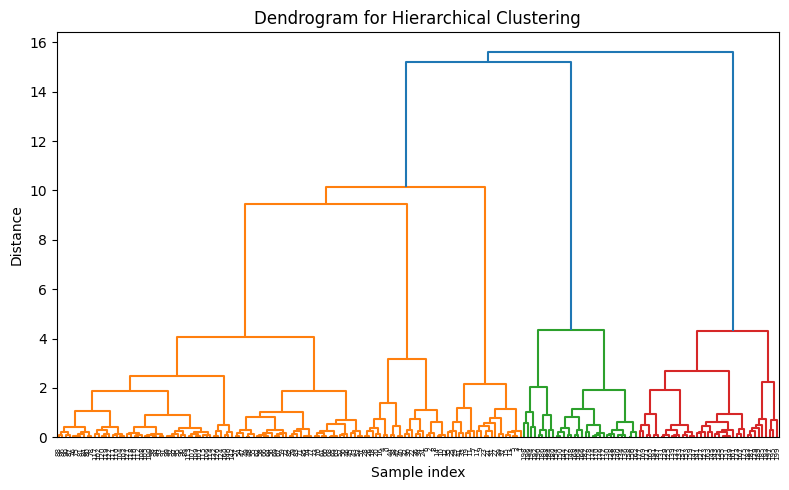

In [64]:
plt.figure(figsize=(8,5))

linked = linkage(x_scaled, method='ward')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

hc_baseline = AgglomerativeClustering(n_clusters=3).fit(x_scaled)
hc_labels_base = hc_baseline.labels_
baseline_results["HIERARCHICAL"] = evaluate_model("Hierarchical", hc_labels_base)


## DBSCAN Clustering

In [65]:
dbscan_baseline = DBSCAN(eps=0.5, min_samples=5).fit(x_scaled)
dbscan_labels_base = dbscan_baseline.labels_
baseline_results["DBSCAN"] = evaluate_model("DBSCAN", dbscan_labels_base)



## BIRCH Clustering

# 3. HYPERPARAMETER TUNING

In [66]:
evaluation_results = {}
best_k = max(range(2,11), key=lambda k: silhouette_score(x_scaled, KMeans(n_clusters=k, random_state=42).fit_predict(x_scaled)))
kmeans_opt = KMeans(n_clusters=best_k, random_state=42).fit(x_scaled)
evaluation_results["KMeans"] = evaluate_model("KMeans", kmeans_opt.labels_) 


best_km = max(range(2,11), key=lambda k: silhouette_score(x_scaled, KMedoids(n_clusters=k, random_state=42).fit_predict(x_scaled)))
kmedoids_opt = KMedoids(n_clusters=best_km, random_state=42).fit(x_scaled)
evaluation_results["KMedoids"] = evaluate_model("KMedoids", kmedoids_opt.labels_) 

best_khc = max(range(2,11), key=lambda k: silhouette_score(x_scaled, AgglomerativeClustering(n_clusters=k).fit_predict(x_scaled)))
hc_opt = AgglomerativeClustering(n_clusters=best_khc).fit(x_scaled)
evaluation_results["Hierarchical"] = evaluate_model("Hierarchical", hc_opt.labels_)


best_score, best_params = -1, {}
for eps in np.arange(0.1, 1.0, 0.1):
    for min_samples in range(3,10):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(x_scaled)
        if len(set(labels) - {-1}) > 1:
            score = silhouette_score(x_scaled[labels != -1], labels[labels != -1])
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

dbscan_opt = DBSCAN(**best_params).fit(x_scaled)
evaluation_results["DBSCAN"] = evaluate_model("DBSCAN", dbscan_opt.labels_)

# 5. COMPARATIVE ANALYSIS

In [67]:
baseline_df = pd.DataFrame(baseline_results).T.round(3)
optimized_df = pd.DataFrame(evaluation_results).T.round(3)
baseline_df

,Silhouette,CH,DB,ARI
KMEANS,-1,-1,-1,-1
KMEDOIDS,-1,-1,-1,-1
HIERARCHICAL,-1,-1,-1,-1
DBSCAN,-1,-1,-1,-1


In [68]:
optimized_df

,Silhouette,CH,DB,ARI
KMeans,-1,-1,-1,-1
KMedoids,-1,-1,-1,-1
Hierarchical,-1,-1,-1,-1
DBSCAN,-1,-1,-1,-1


# What happens when all predictors are considered?